# 1. Importing Libraries

In [3]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

# 2. Data Preparation

In [4]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)   

,dirname,filename
89,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
81,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
142,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
31,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
45,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
166,../input/liver-tumor-segmentation/volume_pt5,volume-50.nii
27,../input/liver-tumor-segmentation/volume_pt1,volume-6.nii
30,../input/liver-tumor-segmentation/volume_pt1,volume-7.nii
21,../input/liver-tumor-segmentation/volume_pt1,volume-8.nii


In [5]:
# Map CT scan and label 


df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,../input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,../input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,../input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,../input/liver-tumor-segmentation/volume_pt2,volume-11.nii,../input/liver-tumor-segmentation/segmentations,segmentation-11.nii
4,../input/liver-tumor-segmentation/volume_pt2,volume-12.nii,../input/liver-tumor-segmentation/segmentations,segmentation-12.nii
5,../input/liver-tumor-segmentation/volume_pt2,volume-13.nii,../input/liver-tumor-segmentation/segmentations,segmentation-13.nii
6,../input/liver-tumor-segmentation/volume_pt2,volume-14.nii,../input/liver-tumor-segmentation/segmentations,segmentation-14.nii
7,../input/liver-tumor-segmentation/volume_pt2,volume-15.nii,../input/liver-tumor-segmentation/segmentations,segmentation-15.nii
8,../input/liver-tumor-segmentation/volume_pt2,volume-16.nii,../input/liver-tumor-segmentation/segmentations,segmentation-16.nii
9,../input/liver-tumor-segmentation/volume_pt2,volume-17.nii,../input/liver-tumor-segmentation/segmentations,segmentation-17.nii


# 3. Data Preprocessing

In [6]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [7]:
# Read sample

sample = 40
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 74)
Mask Shape: (512, 512, 74)


In [8]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

# plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

# Data Visualization
## Display Sample Images

In [9]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

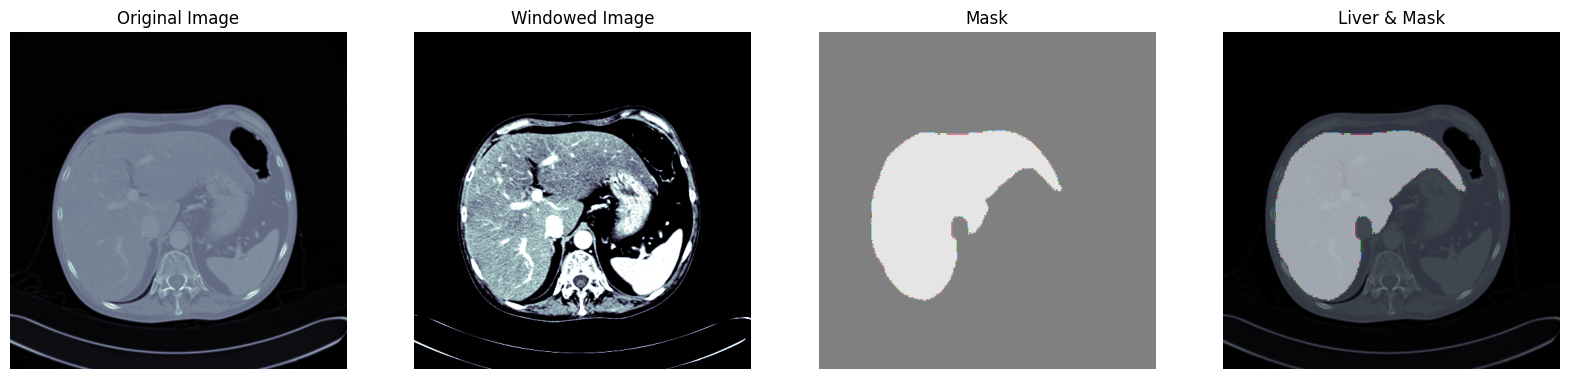

In [10]:
sample = 45

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

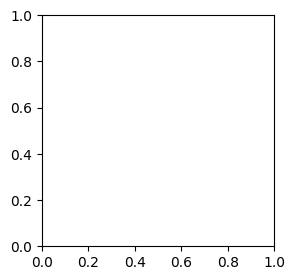

In [11]:
# Preprocessing functions
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'} #a subclass of a PyTorch Tensor designed to handle black-and-white images.

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)


@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120): #unction to convert the tensor to a multi-channel image suitable for saving as a JPG.The image is saved with the specified quality.
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

# sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
# show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

# 4. Generate Training Image From 'nii' File

In [12]:
from sklearn.model_selection import train_test_split

GENERATE_JPG_FILES = True

if GENERATE_JPG_FILES:

    path = Path(".")

    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)

    ## test folder
    os.makedirs('test_images', exist_ok=True)
    os.makedirs('test_masks', exist_ok=True)

    # Split the data into train and test sets
    train_df, test_df = train_test_split(df_files, test_size=0.1, random_state=42)

    # Check if train_df is empty
    print("Length of train_df:", len(train_df))

    # Reset index for contiguous indices
    train_df = train_df.reset_index(drop=True)
    # Check if test_df is empty
    print("Length of test_df:", len(test_df))
    test_df = test_df.reset_index(drop=True)

    # Loop for training set
    for ii in tqdm(range(len(train_df))):
        curr_ct = read_nii(train_df.loc[ii, 'dirname'] + "/" + train_df.loc[ii, 'filename'])
        curr_mask = read_nii(train_df.loc[ii, 'mask_dirname'] + "/" + train_df.loc[ii, 'mask_filename'])
        curr_file_name = str(train_df.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]

        for curr_slice in range(0, curr_dim, 2):
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")

    ### test image save
    for ii in tqdm(range(len(test_df))):
        curr_ct = read_nii(test_df.loc[ii, 'dirname'] + "/" + test_df.loc[ii, 'filename'])
        curr_mask = read_nii(test_df.loc[ii, 'mask_dirname'] + "/" + test_df.loc[ii, 'mask_filename'])
        curr_file_name = str(test_df.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]

        for curr_slice in range(0, curr_dim, 2):
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"test_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"test_masks/{curr_file_name}_slice_{curr_slice}_mask.png")

else:
    path = Path("../input/liver-segmentation-with-fastai-v2")  # read jpg from saved kernel output

Length of train_df: 45
Length of test_df: 6


  0%|          | 0/45 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


  0%|          | 0/6 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


## 4.1 - Check Data

In [13]:
print("\nFirst few rows of Training Set:")
print(train_df.head())

print("\nFirst few rows of Testing Set:")
print(test_df.head())


First few rows of Training Set:
                                        dirname       filename  \
0  ../input/liver-tumor-segmentation/volume_pt3  volume-24.nii   
1  ../input/liver-tumor-segmentation/volume_pt4  volume-38.nii   
2  ../input/liver-tumor-segmentation/volume_pt2  volume-11.nii   
3  ../input/liver-tumor-segmentation/volume_pt4  volume-36.nii   
4  ../input/liver-tumor-segmentation/volume_pt2  volume-20.nii   

                                      mask_dirname        mask_filename  
0  ../input/liver-tumor-segmentation/segmentations  segmentation-24.nii  
1  ../input/liver-tumor-segmentation/segmentations  segmentation-38.nii  
2  ../input/liver-tumor-segmentation/segmentations  segmentation-11.nii  
3  ../input/liver-tumor-segmentation/segmentations  segmentation-36.nii  
4  ../input/liver-tumor-segmentation/segmentations  segmentation-20.nii  

First few rows of Testing Set:
                                        dirname       filename  \
0  ../input/liver-tumor-segm

In [14]:
print("\ntrain df data shape:")
print(train_df.shape)


train df data shape:
(45, 4)


In [15]:
print("\ntest df data shape:")
print(test_df.shape)


test df data shape:
(6, 4)


# 5. Resizing Images

In [16]:
# Set the directories
train_images_dir = '/kaggle/working/train_images'
train_masks_dir = '/kaggle/working/train_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(train_images_dir))

# Determine the sample size
sample_size = min(9000, len(all_image_file_names))

# Randomly select images
selected_image_file_names = random.sample(all_image_file_names, sample_size)

# Load selected images and masks with resizing nd converted to numpy arrays
target_size = (128, 128)
train_images = [np.array(Image.open(os.path.join(train_images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks 
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
train_masks = [np.array(Image.open(os.path.join(train_masks_dir, fname)).resize(target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays  for further processing
train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Normalize images to [0, 1]
train_images =train_images / 255.0

# Reshape masks to include a channel dimension
train_masks =train_masks.reshape((train_masks.shape[0], train_masks.shape[1], train_masks.shape[2], 1))

In [17]:
# Set the directories
test_images_dir = '/kaggle/working/test_images'
test_masks_dir = '/kaggle/working/test_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(test_images_dir))

# Determine the sample size
sample_size = min(9000, len(all_image_file_names))

# Randomly select images
selected_image_file_names = random.sample(all_image_file_names, sample_size)

# Load selected images and masks with resizing
target_size = (128, 128)
test_images = [np.array(Image.open(os.path.join(test_images_dir, fname)).resize
                        (target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
test_masks = [np.array(Image.open(os.path.join(test_masks_dir, fname)).resize
                       (target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Normalize images to [0, 1]
test_images =test_images / 255.0

# Reshape masks to include a channel dimension
test_masks =test_masks.reshape((test_masks.shape[0], test_masks.shape[1], test_masks.shape[2], 1))

In [18]:
print(f"Train image ={len(train_images)} Test image={len(test_images)}")
print(f"Train mask ={len(train_masks)}  Test mask={len(test_masks)}")

Train image =8556 Test image=699
Train mask =8556  Test mask=699


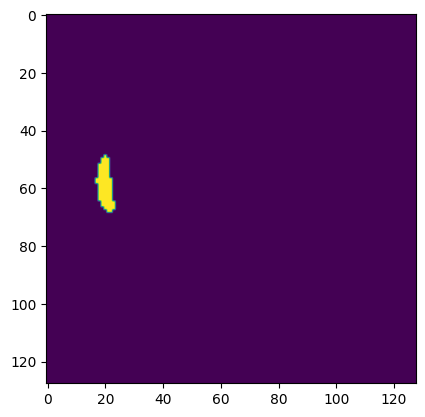

In [19]:
plt.imshow(test_masks[20])

# 6. Spliting Data Train Test and Validation

In [20]:
x_valid, x_test, y_valid, y_test = train_test_split(test_images, test_masks, test_size=1/3, random_state=42)

In [21]:
print(f"train image={train_images.shape} and train_masks={train_masks.shape}")
print(f"X valid shape ={x_valid.shape} x_test={x_test.shape}")
print(f"y valid shape ={y_valid.shape}  y_test={y_test.shape}")

train image=(8556, 128, 128, 3) and train_masks=(8556, 128, 128, 1)
X valid shape =(466, 128, 128, 3) x_test=(233, 128, 128, 3)
y valid shape =(466, 128, 128, 1)  y_test=(233, 128, 128, 1)


## 6.2  Display Random Images and Masks

In [22]:
def display_images_and_masks(images, masks, num_samples=2):
    # Randomly select 'num_samples' number of indices from the available images.
    sample_indices = random.sample(range(images.shape[0]), num_samples)
    
    # Loop through each sample.
    for i in range(num_samples):
        index = sample_indices[i]  # Get the index of the current sample.
        
        #  Display the image.
        plt.subplot(num_samples, 2, 2 * i + 1)  # Prepare a subplot.
        plt.imshow(images[index])  # Show the image at the selected index.
        plt.title("Image {}".format(index))  # Set the title for the image.
        plt.axis("off")  # Turn off the axis.
        
        #  Display the corresponding mask.
        plt.subplot(num_samples, 2, 2 * i + 2)  # Prepare the next subplot.
        plt.imshow(masks[index].squeeze(), cmap='gray')  # Show the mask with a grayscale colormap.
        plt.title("Mask {}".format(index))  # Set the title for the mask.
        plt.axis("off")  # Turn off the axis.
    
    # Display all the subplots.
    plt.show()

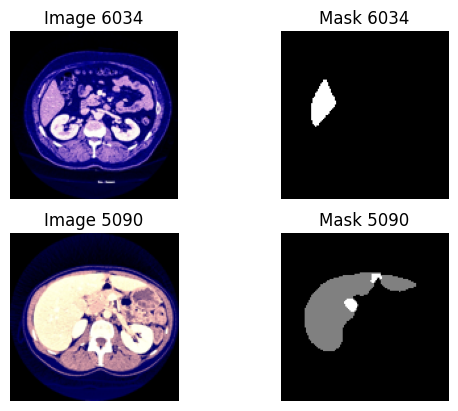

In [23]:
# Display two random images and masks
display_images_and_masks(train_images, train_masks)

# 7. Model Training

## 7.1 - ResNet50 Model

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D

In [48]:
def build_model(input_shape=(128, 128, 3), num_classes=1, weights_path=None):
    # Load the ResNet50 model with the option to load pre-trained weights and excluding the top (fully connected) layers.
    base_model = ResNet50(include_top=False, input_tensor=Input(shape=input_shape))

    # Freeze the layers of the base model to prevent them from being updated during training.
    for layer in base_model.layers:
        layer.trainable = False

    # Start building the custom layers on top of the base model's output.
    x = base_model.output

    # Begin upsampling and adding convolutional layers to build the segmentation head.
    x = UpSampling2D((2, 2))(x)  # Upsample the feature map to increase its spatial dimensions.
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)  # Add a convolutional layer with 512 filters.
    x = UpSampling2D((2, 2))(x)  # Continue upsampling.
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # Add another convolutional layer with 256 filters.
    x = UpSampling2D((2, 2))(x)  # And so on...
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Add the final convolutional layer with a filter for each class (in this case, binary, so only 1 filter).
    x = Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    # Create the model object by specifying the inputs and outputs.
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model with an optimizer, loss function, and metrics to monitor.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Return the compiled model.
    return model

In [49]:
#calling the build_model function to create a new model based on the ResNet50 architecture
model = build_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 7.2 Train the Model

*'train_images' are the input images for training.*

*train_masks' are the corresponding ground truth masks for the input images.*

*'batch_size' is set to 32, meaning the model will update weights after every 32 samples.*

*'epochs' is set to 10, meaning the model will go through the entire dataset 10 times.* 

*'validation_data' is a tuple containing the validation dataset and its corresponding masks.*

*The model's performance is evaluated on this validation dataset after each epoch.*
poch.

In [50]:
history = model.fit(train_images, train_masks, batch_size=32, epochs=10, validation_data=(x_valid, y_valid))

Epoch 1/10


I0000 00:00:1733124270.664470     145 service.cc:145] XLA service 0x7dadd80036d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733124270.664543     145 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/268 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.4035 - loss: 0.5948 

I0000 00:00:1733124279.825156     145 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


268/268 ━━━━━━━━━━━━━━━━━━━━ 46s 110ms/step - accuracy: 0.9571 - loss: 0.1003 - val_accuracy: 0.9864 - val_loss: 0.0339
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9872 - loss: 0.0299 - val_accuracy: 0.9857 - val_loss: 0.0369
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9804 - loss: 0.0458 - val_accuracy: 0.9857 - val_loss: 0.0500
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9807 - loss: 0.0464 - val_accuracy: 0.9814 - val_loss: 0.0487
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9884 - loss: 0.0330 - val_accuracy: 0.9870 - val_loss: 0.0385
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9884 - loss: 0.0305 - val_accuracy: 0.9873 - val_loss: 0.0375
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9901 - loss: 0.0244 - val_accuracy: 0.9877 - val_loss: 0.0329
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9908 - loss: 0.0206 - val_accura

In [51]:
def plot_history(history):
    # Plot the training loss values
    plt.plot(history.history['loss'])
    # Plot the validation loss values
    plt.plot(history.history['val_loss'])
    # Set the title of the plot to 'Model loss'
    plt.title('Model loss')
    # Set the y-axis label of the plot to 'Loss'
    plt.ylabel('Loss')
    # Set the x-axis label of the plot to 'Epoch'
    plt.xlabel('Epoch')
    # Add a legend to the plot with labels 'Train' for training loss and 'Validation' for validation loss
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot
    plt.show()

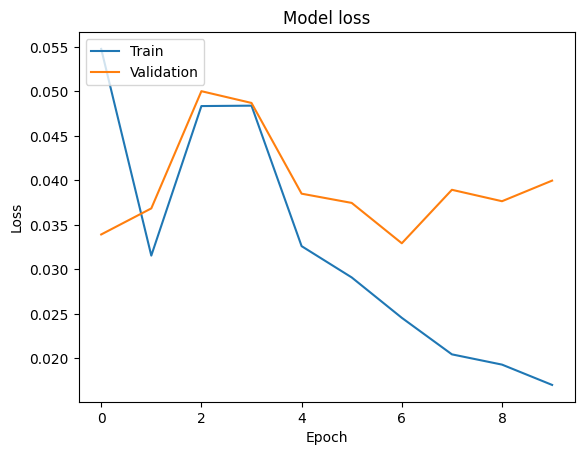

In [52]:
# Plotting the loss curve
plot_history(history)

In [53]:
def plot_history(history):
    # Plot the training loss values
    plt.plot(history.history['accuracy'])
    # Plot the validation loss values
    plt.plot(history.history['val_accuracy'])
    # Set the title of the plot to 'Model loss'
    plt.title('Model loss')
    # Set the y-axis label of the plot to 'Loss'
    plt.ylabel('Loss')
    # Set the x-axis label of the plot to 'Epoch'
    plt.xlabel('Epoch')
    # Add a legend to the plot with labels 'Train' for training loss and 'Validation' for validation loss
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot
    plt.show()

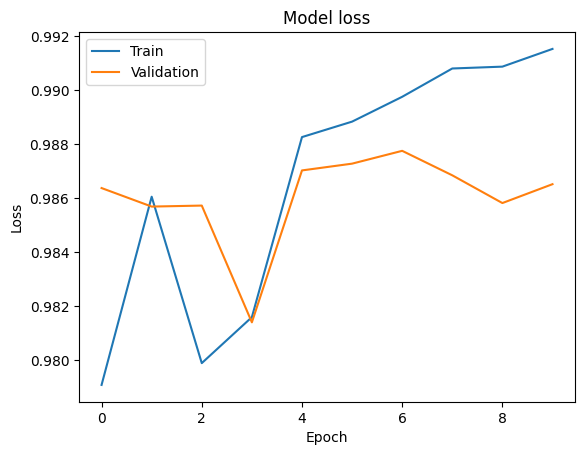

In [54]:
# Plotting the accuracy curve
plot_history(history)

# 8. Model Evaluation

In [55]:
# Evaluate the model using the validation dataset.
# 'x_valid' are the input images for validation.
# 'y_valid' are the corresponding ground truth masks for the validation images.
scores = model.evaluate(x_valid, y_valid)

# 'scores' is a list containing the loss as the first element and the accuracy as the second element.
# By accessing 'scores[1]', we retrieve the accuracy of the model on the validation dataset.
accuracy = scores[1]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9875 - loss: 0.0364


In [56]:
print("Validation Accuracy: ", accuracy)

Validation Accuracy:  0.9865095019340515


In [57]:
prediction = model.predict(x_test)# Use the trained model to make predictions on the test dataset.

# 'x_test' contains the input images for testing.
prediction = model.predict(x_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 756ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [58]:
# Evaluate the model using the test data (x_test, y_test)
test_scores = model.evaluate(x_test, y_test)

# test_scores is a list that contains the loss as the first element and the accuracy as the second element.
# Here, we are accessing the second element, which is the accuracy of the model on the test data.
accuracy = test_scores[1]

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.9847 - loss: 0.0461


In [59]:
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.985007107257843


# 9. Making Final Prediction 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


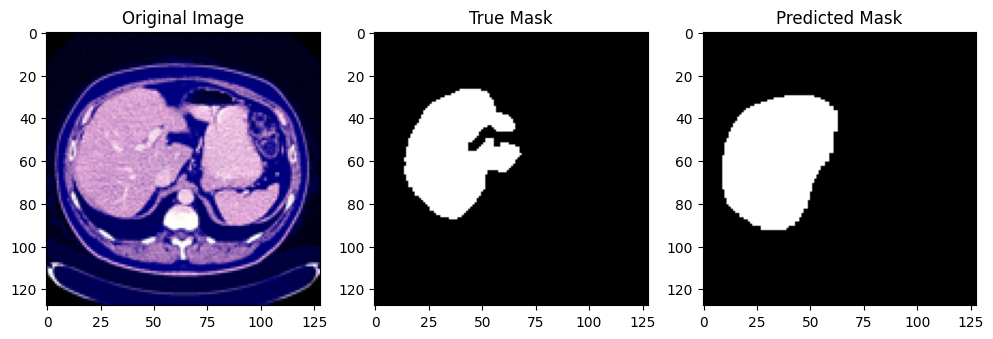

In [67]:
image_index = 1

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Obtain the predicted mask from model2
predicted_mask = model.predict(np.expand_dims(input_image, axis=0))[0]

# Threshold the predicted mask (assuming it's a binary mask)
threshold = 0.1  # Adjust this threshold based on your model's output
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary, cmap='gray')
plt.title('Predicted Mask')

plt.show()

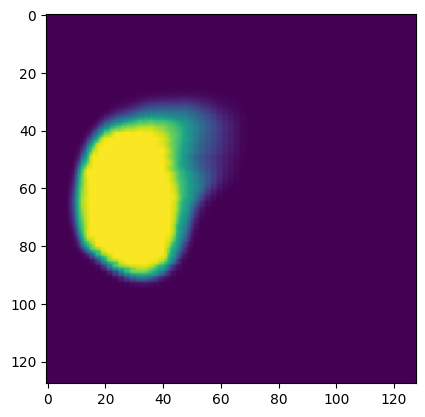

In [68]:
plt.imshow(predicted_mask)

# 10. U-Net Model

In [24]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the U-Net model architecture with detailed comments
def unet_model(input_layer):
    # Encoder
    # First convolutional block with 64 filters and relu activation, same padding keeps dimensions unchanged
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    # First pooling layer reduces spatial dimensions by half (downsampling)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Second convolutional block with 128 filters, following the downsampling
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    # Second pooling layer continues to reduce dimensions
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Decoder
    # Third convolutional block, placed in the decoder part with upsampling coming next
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    # Upsampling layer to increase the spatial dimensions to match those of conv2
    up1 = UpSampling2D((2, 2))(conv3)
    # Concatenation layer merges feature maps from encoder (conv2) with upsampled maps, crucial for U-Net architecture
    concat1 = concatenate([conv2, up1], axis=-1)
    
    # Fourth convolutional block after concatenation to refine features
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    # Final upsampling to increase the dimensions to match those of conv1
    up2 = UpSampling2D((2, 2))(conv4)
    # Final concatenation with the very first convolutional layer outputs
    concat2 = concatenate([conv1, up2], axis=-1)
    
    # Output layer with a single filter and sigmoid activation to produce a binary segmentation map
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(concat2)
    
    # Create the model instance with specified inputs and outputs
    model = Model(inputs=input_layer, outputs=outputs)
    return model

# Instantiate the U-Net model specifying the input shape
input_layer = Input(shape=(128, 128, 3), name='input_layer_1')
unet_model = unet_model(input_layer)

# Compile the model specifying optimizer, loss function, and metrics for evaluation
unet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the U-Net model on the provided training data, also include validation data for evaluating performance
history= unet_model.fit(train_images, train_masks, batch_size=32, epochs=50, validation_data=(x_valid, y_valid))

Epoch 1/50


I0000 00:00:1734021017.644977     103 service.cc:145] XLA service 0x7f2f40046950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734021017.645050     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/268 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8950 - loss: 0.6624

I0000 00:00:1734021023.032217     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9728 - loss: 0.2356 - val_accuracy: 0.9845 - val_loss: 0.0411
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9859 - loss: 0.0376 - val_accuracy: 0.9864 - val_loss: 0.0343
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9868 - loss: 0.0330 - val_accuracy: 0.9867 - val_loss: 0.0318
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9873 - loss: 0.0306 - val_accuracy: 0.9859 - val_loss: 0.0354
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9874 - loss: 0.0305 - val_accuracy: 0.9869 - val_loss: 0.0316
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9886 - loss: 0.0272 - val_accuracy: 0.9866 - val_loss: 0.0322
Epoch 7/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9891 - loss: 0.0258 - val_accuracy: 0.9886 - val_loss: 0.0273
Epoch 8/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9895 - loss: 0.0245 - val_accuracy: 0.98

In [25]:
def plot_history(history):
    # Plot the training loss values
    plt.plot(history.history['loss'])
    # Plot the validation loss values
    plt.plot(history.history['val_loss'])
    # Set the title of the plot to 'Model loss'
    plt.title('Model loss')
    # Set the y-axis label of the plot to 'Loss'
    plt.ylabel('Loss')
    # Set the x-axis label of the plot to 'Epoch'
    plt.xlabel('Epoch')
    # Add a legend to the plot with labels 'Train' for training loss and 'Validation' for validation loss
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot
    plt.show()

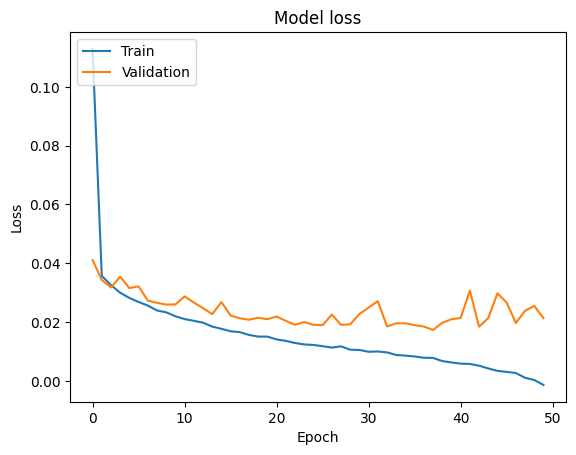

In [26]:
# Plotting the loss curve
plot_history(history)

In [23]:
def plot_history(history):
    # Plot the training loss values
    plt.plot(history.history['accuracy'])
    # Plot the validation loss values
    plt.plot(history.history['val_accuracy'])
    # Set the title of the plot to 'Model loss'
    plt.title('Model loss')
    # Set the y-axis label of the plot to 'Loss'
    plt.ylabel('Loss')
    # Set the x-axis label of the plot to 'Epoch'
    plt.xlabel('Epoch')
    # Add a legend to the plot with labels 'Train' for training loss and 'Validation' for validation loss
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot
    plt.show()

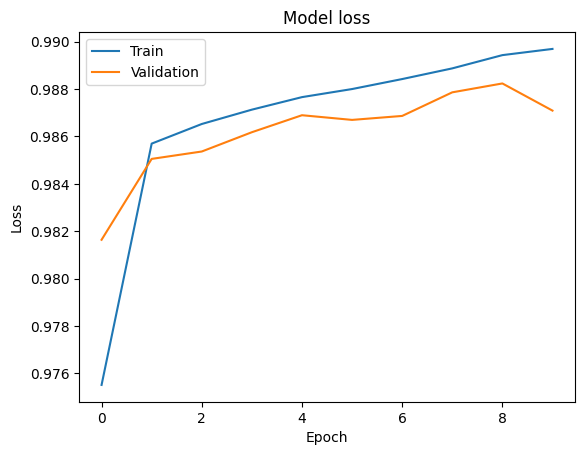

In [24]:
# Plotting the accuracy curve
plot_history(history)

## 10.2 Evaluating U-Net Model

In [25]:
# Evaluate the performance of the trained U-Net model on the test dataset
evaluation = unet_model.evaluate(x_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9876 - loss: 0.0327


In [26]:
accuracy = evaluation[1]

In [27]:
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.9878183603286743


## 10.3 Making Prediction with U-Net Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


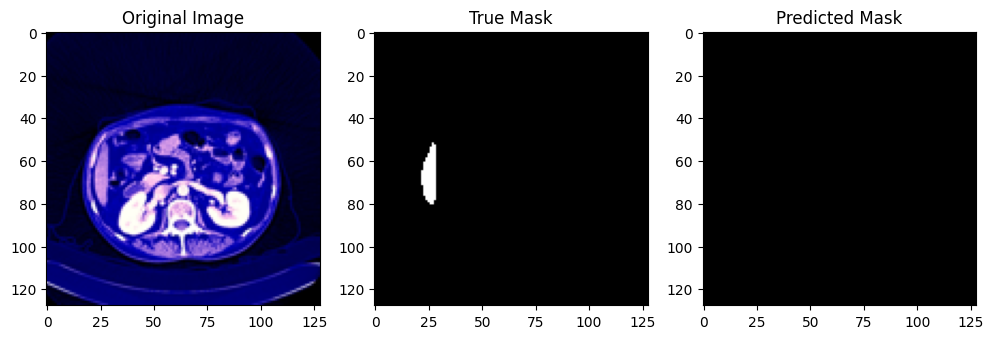

In [28]:
# Import the numpy library for numerical operations and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt

# Select an index for the image to be visualized and analyzed
image_index = 55

# Load the image and corresponding true mask from the test dataset
input_image = x_test[image_index]  # The input image to the model
true_mask = y_test[image_index]    # The ground truth mask for the input image

# Obtain the predicted mask from the U-Net model
predicted_mask = unet_model.predict(np.expand_dims(input_image, axis=0))[0]  # Model prediction for the input image

# Apply a threshold to convert the predicted mask to a binary mask
threshold = 0.5  
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)  # Binary version of the predicted mask

# Set up the plotting environment with a figure size
plt.figure(figsize=(12, 4))

# Plot the original image in the first subplot
plt.subplot(1, 3, 1)
plt.imshow(input_image)  # Display the original image
plt.title('Original Image')  # Title for the first subplot

# Plot the true mask in the second subplot
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')  # Display the true mask in grayscale
plt.title('True Mask')  # Title for the second subplot

# Plot the predicted binary mask in the third subplot
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')  # Display the binary predicted mask in grayscale
plt.title('Predicted Mask')  # Title for the third subplot

# Display the plots
plt.show()